# Lab work 2 : Logistic regression

This notebook builds on the fourth lecture of Foundations of Machine Learning. We'll focus on the logistic regression model and how to deal with class imbalance.

Important note: the steps shown here are not always the most efficient or the most "industry-approved." Their main purpose is pedagogical. So don't panic if something looks suboptimal—it's meant to be.

If you have questions (theoretical or practical), don't hesitate to bug your lecturer.

We will try to accurately predict if a star observation is actually a [pulsars](https://en.wikipedia.org/wiki/Pulsar) on a [dataset](https://www.kaggle.com/datasets/colearninglounge/predicting-pulsar-starintermediate). Let's first load the dataset.


In [113]:
import pandas as pd

df = pd.read_csv("NB4 - Pulsars.csv")
df.head()

,Mean,Std,Excess_kurtosis,Skewness,target
0,140.562500,55.683782,-0.234571,-0.699648,0
1,102.507812,58.882430,0.465318,-0.515088,0
2,103.015625,39.341649,0.323328,1.051164,0
3,136.750000,57.178449,-0.068415,-0.636238,0
4,88.726562,40.672225,0.600866,1.123492,0


Since this is a classification problem, our first step is to check how imbalanced the classes are.

**Task**: Measure the class imbalance in the dataset by calculating how often the target takes the value of interest (in this case, 1).


In [114]:
zeros, ones = df["target"].value_counts()
print(f"Number of non-pulsars (0): {zeros}")
print(f"Number of pulsars (1): {ones}")
print(f"Class imbalance ratio (0 to 1): {zeros / ones:.2f}")

Number of non-pulsars (0): 16259
Number of pulsars (1): 1639
Class imbalance ratio (0 to 1): 9.92


That means any model with accuracy below 90% is actually worse than a trivial model that always predicts "not a pulsar."

But the challenge doesn't stop at measuring performance—there's also a problem with how we split the data:


In [115]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

imbalance_rate_train = 100 * y_train.mean()
print(f"Interest class rate: {imbalance_rate_train:.2f}% (train)")
imbalance_rate_test = 100 * y_test.mean()
print(f"Interest class rate: {imbalance_rate_test:.2f}% (test)")

Interest class rate: 9.19% (train)
Interest class rate: 9.05% (test)


The [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) function splits the dataset randomly, which means it doesn't preserve the class imbalance in each split.
To fix this, we can use the _stratify_ parameter.

**Task** : Modify the code above to include the _stratify_ parameter, then check the result and conclude.


In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

imbalance_rate_train = 100 * y_train.mean()
print(f"Interest class rate: {imbalance_rate_train:.2f}% (train)")
imbalance_rate_test = 100 * y_test.mean()
print(f"Interest class rate: {imbalance_rate_test:.2f}% (test)")

Interest class rate: 9.16% (train)
Interest class rate: 9.16% (test)


## Data preparation

As always, the bread and butter of data science : data preparation.

**Task** : Inspect the dataset with the [`describe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) method as every column are numerical.


In [117]:
X_train.describe()

,Mean,Std,Excess_kurtosis,Skewness
count,13423.000000,13423.000000,13423.000000,13423.000000
mean,110.994868,46.510522,0.479557,1.774649
std,25.512754,6.806141,1.062579,6.181897
min,5.812500,24.772042,-1.876011,-1.791886
25%,100.871094,42.331218,0.028412,-0.188556
50%,115.007812,46.946339,0.225654,0.195307
75%,127.027344,51.037913,0.471533,0.925991
max,192.617188,91.808628,8.069522,68.101622


**Task** : Given the code below, using [`scatter_matrix`](https://pandas.pydata.org/docs/reference/api/pandas.plotting.scatter_matrix.html) function, interpret its output for our problem.


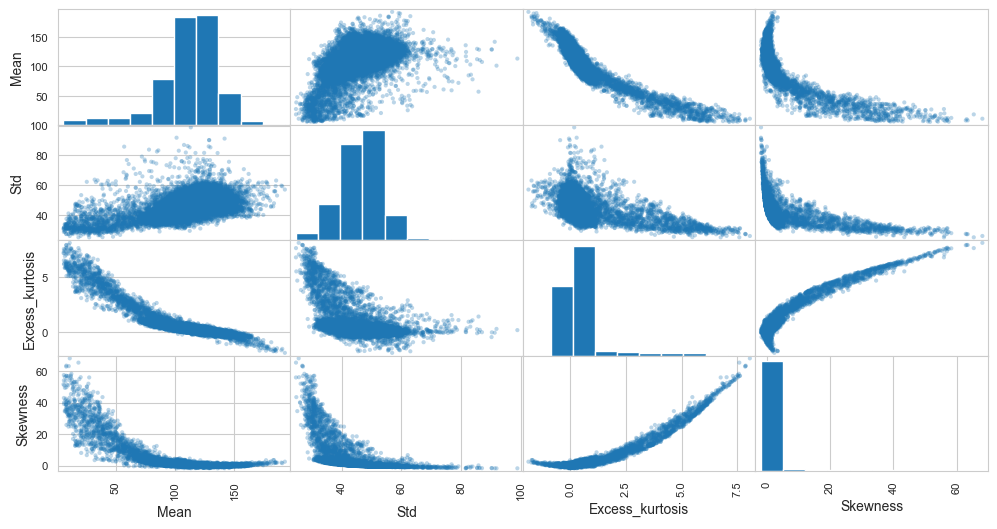

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style="whitegrid")

X = df.drop(columns=["target"])
pd.plotting.scatter_matrix(X, figsize=(12, 6), alpha=0.3)
plt.show()

This figure gives us plenty of insights, but it doesn't show the actual distribution of the two classes.

**Task**: Using the function provided below, re-explore the relationships between the variables and the target.


In [ ]:
def scatter_classification(
    df, target_column, column_1, column_2, figsize=(12, 6), **kwargs
):
    plt.figure(figsize=figsize)
    for index, value in enumerate(df[target_column].unique()):
        subset = df.loc[df["target"] == value,]
        plt.scatter(
            subset[column_1],
            subset[column_2],
            color=sns.color_palette()[index],
            label=f"Class {index}",
            **kwargs,
        )
    plt.title(f"{column_1} vs {column_2}")
    plt.xlabel(column_1)
    plt.ylabel(column_2)
    plt.legend()
    plt.show()

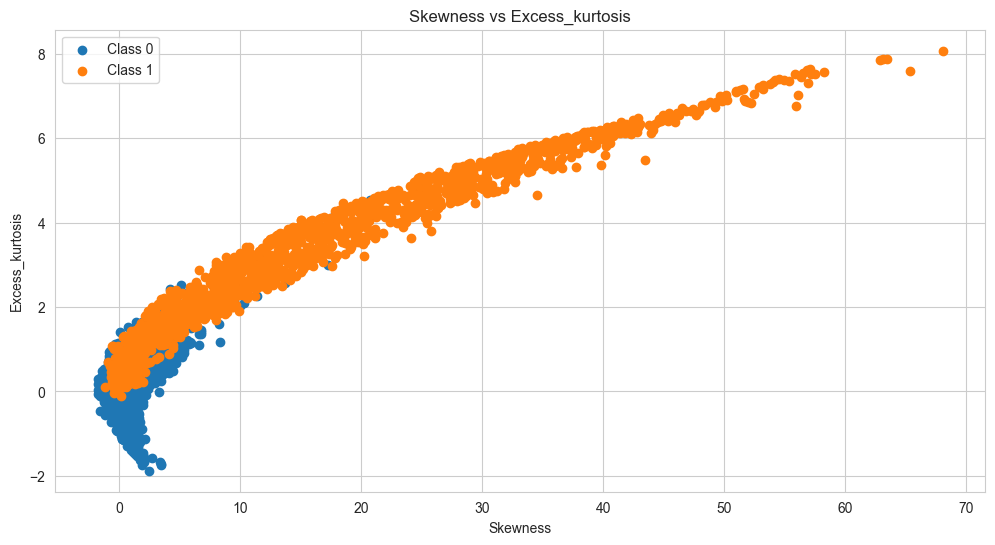

In [120]:
scatter_classification(df, "target", "Skewness", "Excess_kurtosis")

We clearly get that : Skewness = Excess_kurtosis \** 2. Therefore, we decide to remove the Excess_kurtosis variable from our work.
Also, given the name of the column *Mean* and *Std*, we decide to compute the *Z-Score\* variable defined as the ratio between the two.

**Task** : Implement the changes described above.


In [121]:
df_to_model = df.drop(columns=["Excess_kurtosis"])

In [ ]:
X = df_to_model.drop(columns=["target"])
X["Z-Score"] = X["Mean"] / X["Std"]
y = df_to_model["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

Now is time model !

## Modelisation and pipeline

Logistic regression learns its coefficient using variants of gradient descent. Therefore it requires a standardisation of its feature to stabilize the training.

**Task** : Using the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) class, train a [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) after splitting with the [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) function carefully.
Then, display performance metric such as accuracy, precision, recall and F1-Score. One can use the [`precision_recall_fscore_support`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html) function.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(X_train_std, y_train)
y_pred = model.predict(X_test_std)


accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(
    y_true=y_test, y_pred=y_pred, average="binary"
)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

Accuracy: 0.9741
Precision: 0.9682
Recall: 0.7415
F1-Score: 0.8398


The performance are already quite good, as expected ! Currently, we perform two steps when training:

1. Learn and standardize the inputs
2. Train the model

And two steps when predicting:

1. Standardize the input using the scaling learned from training
2. Make predictions

These two workflows are very similar, so we can combine them using a [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) class. The goal is to simplify the code, like this:


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

pipe = Pipeline([("scaler", StandardScaler()), ("logistic", LogisticRegression())])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(
    y_true=y_test, y_pred=y_pred, average="binary"
)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

Accuracy: 0.9741
Precision: 0.9682
Recall: 0.7415
F1-Score: 0.8398


We highly encourage to use the `Pipeline` class to avoid data leakage when applying the `StandardScaler`.

## Choosing the right threshold

Logistic regression outputs a score that can be interpreted as a probability. By default, this score is converted into class labels (0 or 1) using a threshold of 0.5
But what if 0.5 isn't the best threshold for optimizing the F1-score?

**Task** : Compute for several thresholds the precision, recall and F1-Score value. Then make a plot highlighting where the best performance is achieved.


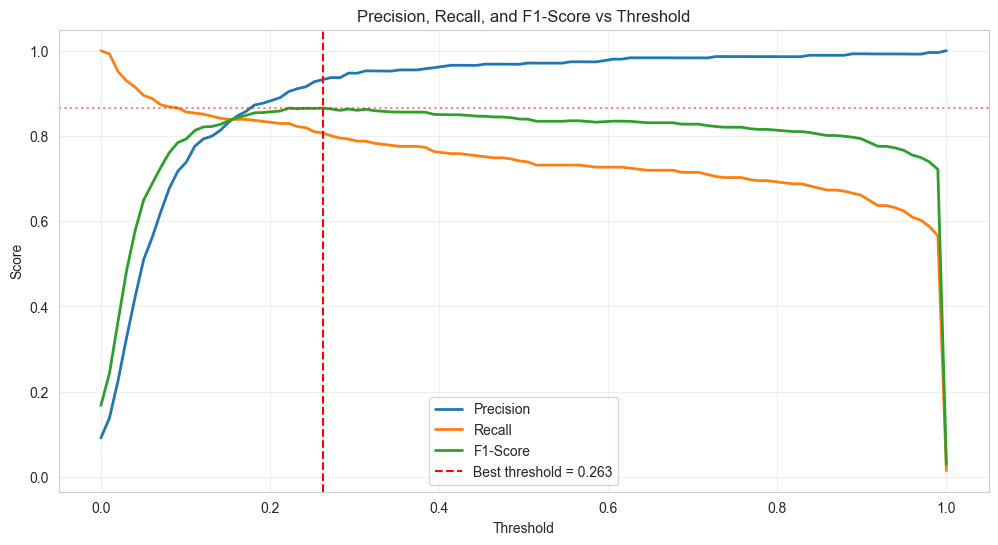

Best threshold: 0.263
Best F1-Score: 0.8654
Precision at best threshold: 0.9324
Recall at best threshold: 0.8073


In [ ]:
import numpy as np

# Get probability scores from the pipeline
y_scores = pipe.predict_proba(X_test)[:, 1]

# Define a range of thresholds to test
thresholds = np.linspace(0, 1, 100)

# Store metrics for each threshold
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    # Convert probabilities to predictions using the current threshold
    y_pred_threshold = (y_scores >= threshold).astype(int)

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true=y_test, y_pred=y_pred_threshold, average="binary", zero_division=0
    )

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Find the best threshold for F1-score
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precisions, label="Precision", linewidth=2)
plt.plot(thresholds, recalls, label="Recall", linewidth=2)
plt.plot(thresholds, f1_scores, label="F1-Score", linewidth=2)
plt.axvline(
    best_threshold,
    color="red",
    linestyle="--",
    label=f"Best threshold = {best_threshold:.3f}",
)
plt.axhline(best_f1, color="red", linestyle=":", alpha=0.5)
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score vs Threshold")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Best threshold: {best_threshold:.3f}")
print(f"Best F1-Score: {best_f1:.4f}")
print(f"Precision at best threshold: {precisions[best_threshold_idx]:.4f}")
print(f"Recall at best threshold: {recalls[best_threshold_idx]:.4f}")

We're going to dive deeper into some topics in the rest of this notebook, so let's first wrap up the useful code.

**Task** : Define a function `train_experiment` which will fit a model given a training dataset, then test this model against a test dataset and display the metrics curves we've just wrote.


In [ ]:
def train_experiment(train_dataset, test_dataset, target_column):
    pipe = Pipeline([("scaler", StandardScaler()), ("logistic", LogisticRegression())])

    X_train = train_dataset.drop(columns=[target_column])
    y_train = train_dataset[target_column]
    X_test = test_dataset.drop(columns=[target_column])
    y_test = test_dataset[target_column]

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Get probability scores from the pipeline
    y_scores = pipe.predict_proba(X_test)[:, 1]

    # Define a range of thresholds to test
    thresholds = np.linspace(0, 1, 100)

    # Store metrics for each threshold
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in thresholds:
        # Convert probabilities to predictions using the current threshold
        y_pred_threshold = (y_scores >= threshold).astype(int)

        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true=y_test, y_pred=y_pred_threshold, average="binary", zero_division=0
        )

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    # Find the best threshold for F1-score
    best_threshold_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_idx]
    best_f1 = f1_scores[best_threshold_idx]

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, precisions, label="Precision", linewidth=2)
    plt.plot(thresholds, recalls, label="Recall", linewidth=2)
    plt.plot(thresholds, f1_scores, label="F1-Score", linewidth=2)
    plt.axvline(
        best_threshold,
        color="red",
        linestyle="--",
        label=f"Best threshold = {best_threshold:.3f}",
    )
    plt.axhline(best_f1, color="red", linestyle=":", alpha=0.5)
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision, Recall, and F1-Score vs Threshold")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"Best threshold: {best_threshold:.3f}")
    print(f"Best F1-Score: {best_f1:.4f}")
    print(f"Precision at best threshold: {precisions[best_threshold_idx]:.4f}")
    print(f"Recall at best threshold: {recalls[best_threshold_idx]:.4f}")

    # Calculate and print scores at threshold 0.5 for fair comparison
    print("\n--- Scores at threshold 0.5 (for comparison) ---")
    y_pred_05 = (y_scores >= 0.5).astype(int)
    acc_05 = accuracy_score(y_test, y_pred_05)
    precision_05, recall_05, f1_05, _ = precision_recall_fscore_support(
        y_test, y_pred_05, average="binary", zero_division=0
    )
    print(f"Accuracy at threshold 0.5: {acc_05:.4f}")
    print(f"Precision at threshold 0.5: {precision_05:.4f}")
    print(f"Recall at threshold 0.5: {recall_05:.4f}")
    print(f"F1-Score at threshold 0.5: {f1_05:.4f}")

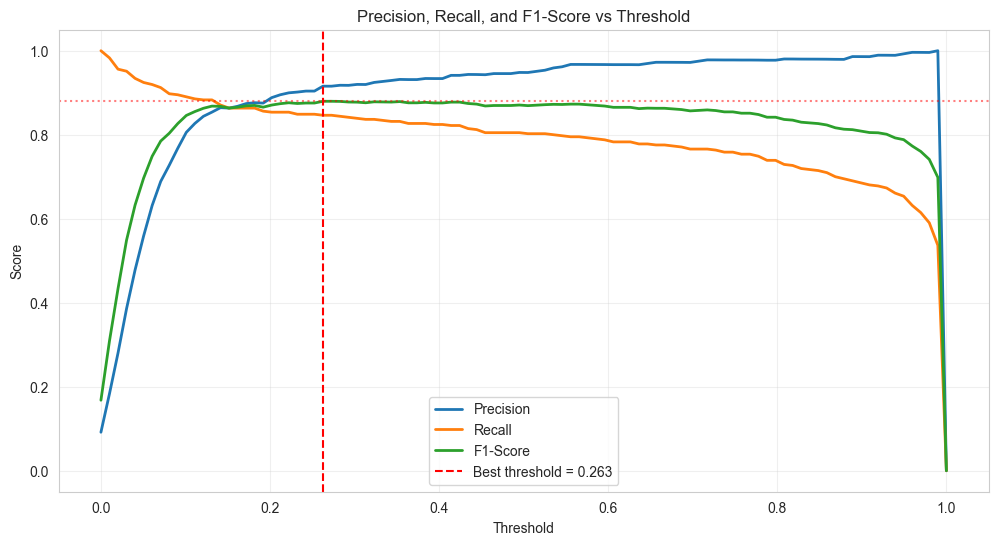

Best threshold: 0.263
Best F1-Score: 0.8796
Precision at best threshold: 0.9156
Recall at best threshold: 0.8463

--- Scores at threshold 0.5 (for comparison) ---
Accuracy at threshold 0.5: 0.9779
Precision at threshold 0.5: 0.9481
Recall at threshold 0.5: 0.8024
F1-Score at threshold 0.5: 0.8692


In [ ]:
train_dataset, test_dataset = train_test_split(
    df, stratify=df["target"], random_state=42
)

train_experiment(train_dataset, test_dataset, target_column="target")

## Handle imbalance

So far, aside from splitting the data and measuring performance, class imbalance hasn't caused much trouble because the problem seems relatively simple.
However, in general, imbalanced datasets often require resampling techniques. We'll cover some of these approaches.

The first method is **random under-sampling**. This technique randomly removes observations from the majority class until the desired ratio between the majority and minority classes is reached.

**Task** : Using the [`RandomUnderSampler`](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html) class, balance the training dataset and measure the number of row before and after. Then, fit as usual and display performance metrics and visuals.


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

train_dataset = X.copy()
train_dataset["target"] = y

train_data, test_data = train_test_split(
    train_dataset, stratify=train_dataset["target"], random_state=42
)

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(
    train_data.drop(columns=["target"]), train_data["target"]
)
print(f"Original training size: {len(train_data)}")
print(f"Undersampled training size: {len(X_res)}")

Original training size: 13423
Undersampled training size: 2458


In [130]:
X_res.shape, y_res.shape

((2458, 4), (2458,))

In [131]:
res_train_dataset = X_res.copy()
res_train_dataset["target"] = y_res

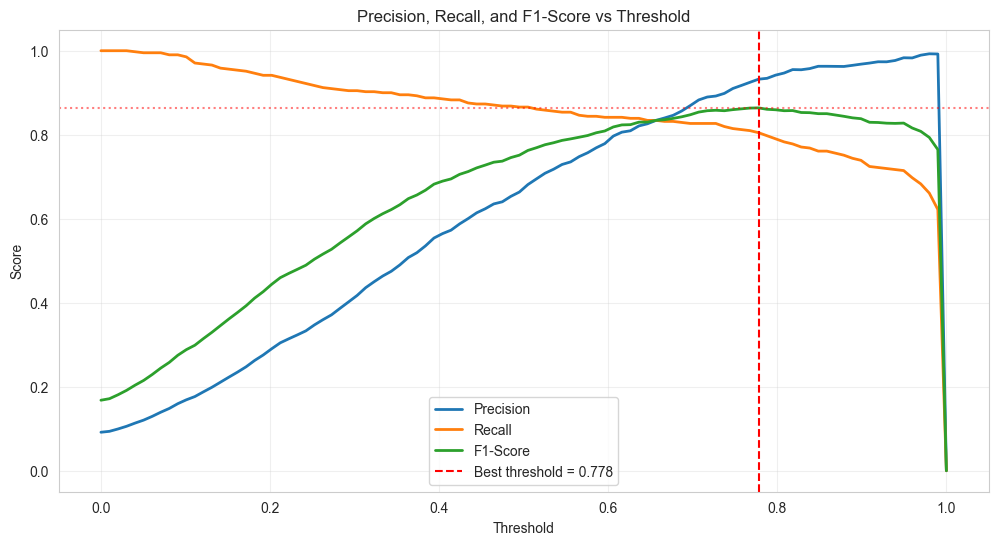

Best threshold: 0.778
Best F1-Score: 0.8639
Precision at best threshold: 0.9322
Recall at best threshold: 0.8049

--- Scores at threshold 0.5 (for comparison) ---
Accuracy at threshold 0.5: 0.9491
Precision at threshold 0.5: 0.6723
Recall at threshold 0.5: 0.8659
F1-Score at threshold 0.5: 0.7569


In [132]:
train_experiment(res_train_dataset, test_data, target_column="target")

The second method works in the opposite direction: we duplicate observations from the minority class until we reach the desired ratio. This is called **random over-sampling**.

**Task** : Using the [`RandomOverSampler`](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html) class, balance the training dataset and measure the number of row before and after. Then, fit as usual and display performance metrics and visuals.


In [ ]:
from imblearn.over_sampling import RandomOverSampler

train_dataset = X.copy()
train_dataset["target"] = y

train_data, test_data = train_test_split(
    train_dataset, stratify=train_dataset["target"], random_state=42
)

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(
    train_data.drop(columns=["target"]), train_data["target"]
)
print(f"Original training size: {len(train_data)}")
print(f"Undersampled training size: {len(X_res)}")

Original training size: 13423
Undersampled training size: 24388


In [134]:
X_res.shape, y_res.shape

((24388, 4), (24388,))

In [135]:
res_train_dataset = X_res.copy()
res_train_dataset["target"] = y_res

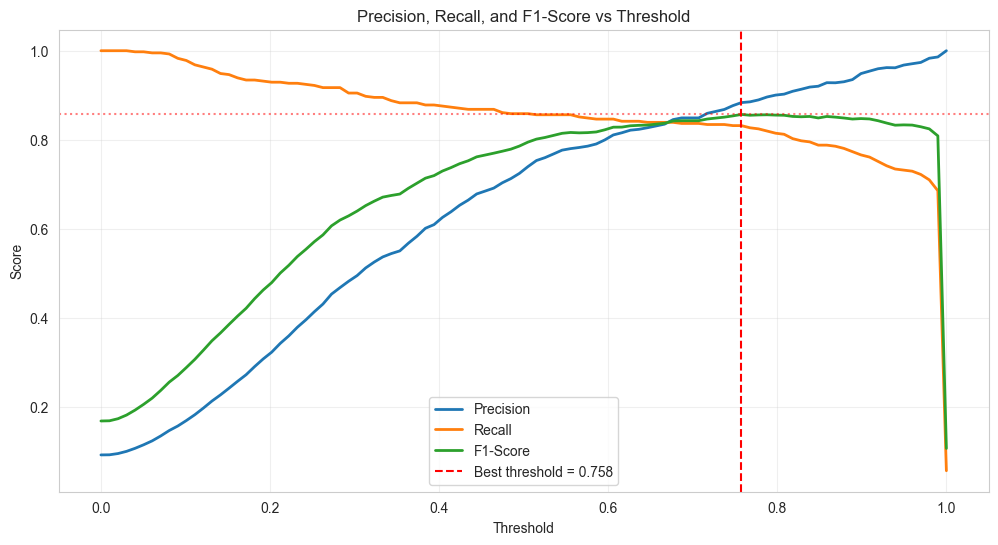

Best threshold: 0.758
Best F1-Score: 0.8568
Precision at best threshold: 0.8834
Recall at best threshold: 0.8317

--- Scores at threshold 0.5 (for comparison) ---
Accuracy at threshold 0.5: 0.9582
Precision at threshold 0.5: 0.7318
Recall at threshold 0.5: 0.8585
F1-Score at threshold 0.5: 0.7901


In [136]:
train_experiment(res_train_dataset, test_data, target_column="target")

Another method, also in the under-sampling family, is [**SMOTE**](https://www.jair.org/index.php/jair/article/view/10302/24590) (Synthetic Minority Over-sampling Technique). Instead of simply duplicating samples, SMOTE creates new observations by interpolating between existing minority-class examples and their neighbors. For a more visual explanation, one can look at [these slides](https://github.com/theo-lq/Conferences/blob/main/M2%20IASD%20Exec%20-%20ML%20LCLF/Support%202024.pdf) (in french).

**Task** : Using the [`SMOTE`](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) class, balance the training dataset and measure the number of row before and after. Then, fit as usual and display performance metrics and visuals.


Original training size: 13423
Undersampled training size: 24388


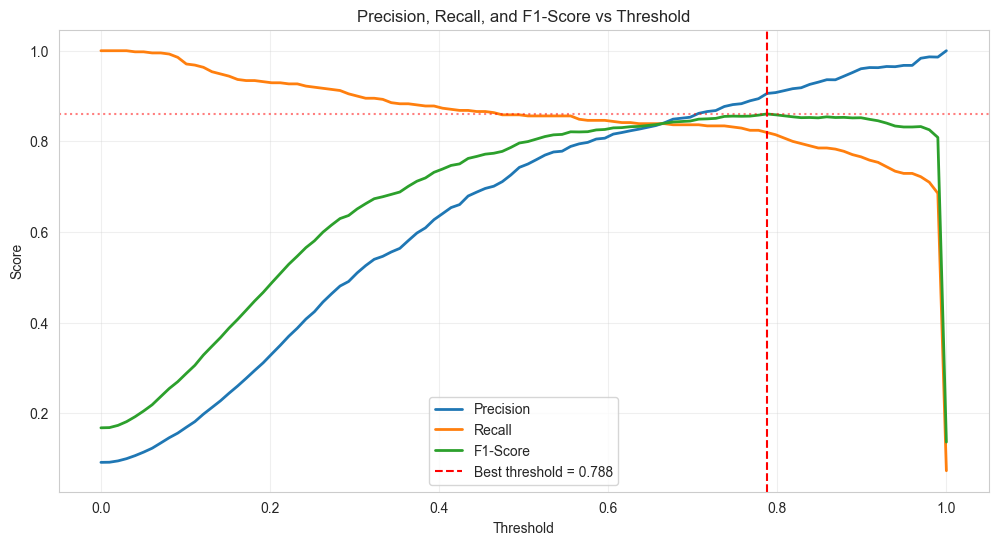

Best threshold: 0.788
Best F1-Score: 0.8604
Precision at best threshold: 0.9057
Recall at best threshold: 0.8195

--- Scores at threshold 0.5 (for comparison) ---
Accuracy at threshold 0.5: 0.9604
Precision at threshold 0.5: 0.7473
Recall at threshold 0.5: 0.8585
F1-Score at threshold 0.5: 0.7991


In [ ]:
from imblearn.over_sampling import SMOTE

train_dataset = X.copy()
train_dataset["target"] = y

train_data, test_data = train_test_split(
    train_dataset, stratify=train_dataset["target"], random_state=42
)

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(
    train_data.drop(columns=["target"]), train_data["target"]
)
print(f"Original training size: {len(train_data)}")
print(f"Undersampled training size: {len(X_res)}")

res_train_dataset = X_res.copy()
res_train_dataset["target"] = y_res

train_experiment(res_train_dataset, test_data, target_column="target")

For our dataset and setup, balancing the dataset didn't improve performance much, but it did affect the model's confidence and calibration.

Another approach, which doesn't require changing the dataset, is to incorporate class imbalance directly into the training loss.

**Task** : Using the _class_weight_ parameter in the [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class, fit a model and display performance metrics and visuals.


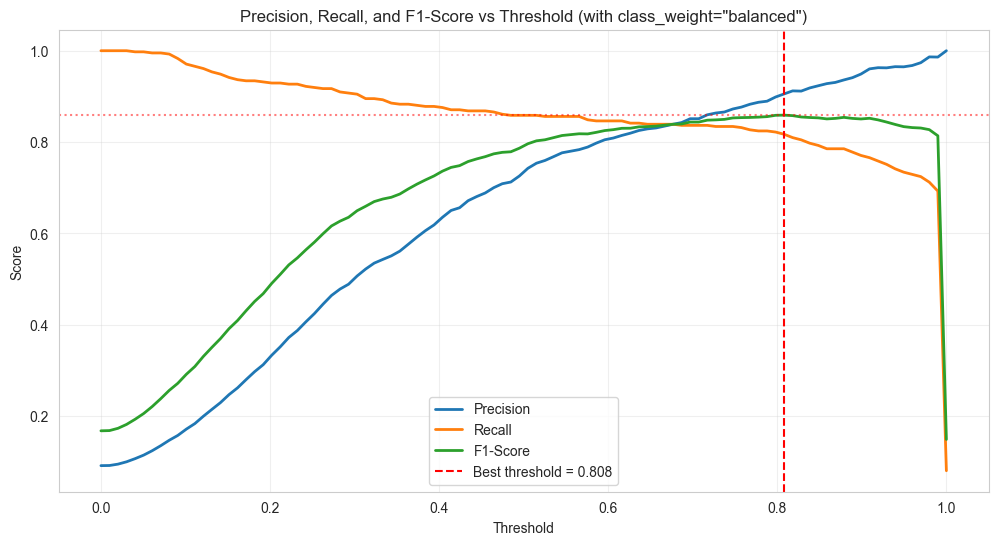

Best threshold: 0.808
Best F1-Score: 0.8590
Precision at best threshold: 0.9054
Recall at best threshold: 0.8171


In [ ]:
# Prepare the data
train_dataset = X.copy()
train_dataset["target"] = y

train_data, test_data = train_test_split(
    train_dataset, stratify=train_dataset["target"], random_state=42
)

# Create a pipeline with class_weight='balanced'
pipe_weighted = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("logistic", LogisticRegression(class_weight="balanced")),
    ]
)

# Fit the model
pipe_weighted.fit(train_data.drop(columns=["target"]), train_data["target"])

# Get predictions and probabilities
y_pred = pipe_weighted.predict(test_data.drop(columns=["target"]))
y_scores = pipe_weighted.predict_proba(test_data.drop(columns=["target"]))[:, 1]

# Calculate metrics across different thresholds
thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_pred_threshold = (y_scores >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true=test_data["target"],
        y_pred=y_pred_threshold,
        average="binary",
        zero_division=0,
    )
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Find best threshold
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precisions, label="Precision", linewidth=2)
plt.plot(thresholds, recalls, label="Recall", linewidth=2)
plt.plot(thresholds, f1_scores, label="F1-Score", linewidth=2)
plt.axvline(
    best_threshold,
    color="red",
    linestyle="--",
    label=f"Best threshold = {best_threshold:.3f}",
)
plt.axhline(best_f1, color="red", linestyle=":", alpha=0.5)
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title('Precision, Recall, and F1-Score vs Threshold (with class_weight="balanced")')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Best threshold: {best_threshold:.3f}")
print(f"Best F1-Score: {best_f1:.4f}")
print(f"Precision at best threshold: {precisions[best_threshold_idx]:.4f}")
print(f"Recall at best threshold: {recalls[best_threshold_idx]:.4f}")

## Question

If i have a model which has better f1 scores and recall and precision at 0.3 threshold, should i always interpret is as being better thena model which has worse scores but at 0.8 threshold? is there a metric that takes thresholds into account?


## Polynomial feature and hyperparameter tuning

As we saw in Session 2, polynomial features can help linear models capture more complex relationships. It's worth trying them again here.

**Task** : Using the [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures) class, process the training set and transform the test set. Then, fit as usual and display performance metrics and visuals.


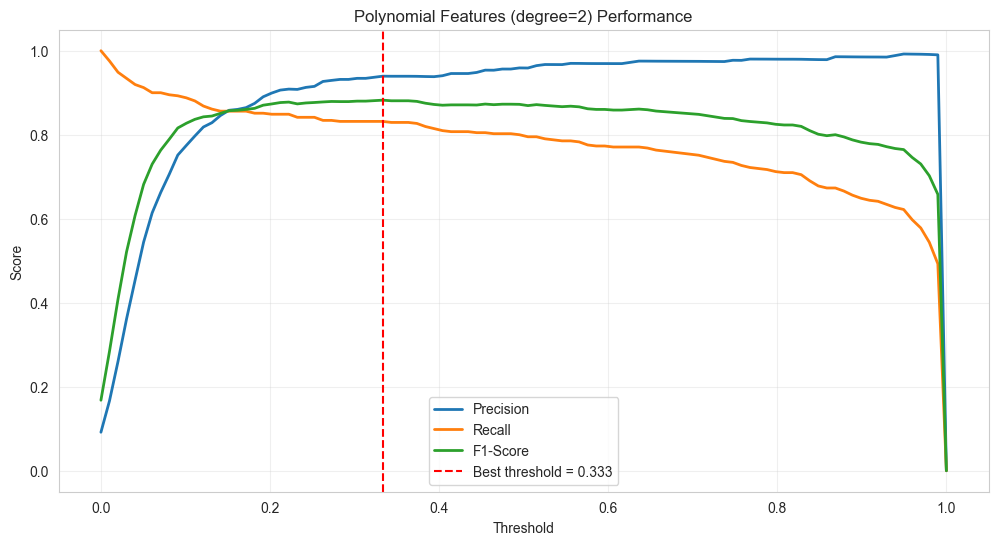

Best threshold: 0.333
Best F1-Score: 0.8823
Precision at best threshold: 0.9394
Recall at best threshold: 0.8317


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Prepare the data
train_dataset = X.copy()
train_dataset["target"] = y

train_data, test_data = train_test_split(
    train_dataset, stratify=train_dataset["target"], random_state=42
)

# Create a pipeline with PolynomialFeatures, StandardScaler, and LogisticRegression
pipe_poly = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2)),
        ("scaler", StandardScaler()),
        ("logistic", LogisticRegression(max_iter=1000)),
    ]
)

# Fit and evaluate
pipe_poly.fit(train_data.drop(columns=["target"]), train_data["target"])

# Get predictions and evaluate
train_experiment_pipeline = lambda: None  # Use the train_experiment logic

# Or manually evaluate:
y_scores = pipe_poly.predict_proba(test_data.drop(columns=["target"]))[:, 1]
thresholds = np.linspace(0, 1, 100)
precisions, recalls, f1_scores = [], [], []

for threshold in thresholds:
    y_pred_threshold = (y_scores >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true=test_data["target"],
        y_pred=y_pred_threshold,
        average="binary",
        zero_division=0,
    )
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

plt.figure(figsize=(12, 6))
plt.plot(thresholds, precisions, label="Precision", linewidth=2)
plt.plot(thresholds, recalls, label="Recall", linewidth=2)
plt.plot(thresholds, f1_scores, label="F1-Score", linewidth=2)
plt.axvline(
    best_threshold,
    color="red",
    linestyle="--",
    label=f"Best threshold = {best_threshold:.3f}",
)
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Polynomial Features (degree=2) Performance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Best threshold: {best_threshold:.3f}")
print(f"Best F1-Score: {best_f1:.4f}")
print(f"Precision at best threshold: {precisions[best_threshold_idx]:.4f}")
print(f"Recall at best threshold: {recalls[best_threshold_idx]:.4f}")

It's a bit better, but there's still room for improvement. Now it's your turn to experiment!


In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import (
    f1_score,
    precision_recall_fscore_support,
    accuracy_score,
    make_scorer,
)

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# X and y are your features and target after dropping Excess_kurtosis and adding Z-Score
train_dataset = X.copy()
train_dataset["target"] = y

train_data, test_data = train_test_split(
    train_dataset, stratify=train_dataset["target"], random_state=42
)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best hyperparameters: {'logistic__C': 1.0, 'logistic__class_weight': None, 'poly__degree': 2}
Best CV F1 (train/val): 0.8478
Best hyperparameters: {'logistic__C': 1.0, 'logistic__class_weight': None, 'poly__degree': 2}
Best CV F1 (train/val): 0.8478


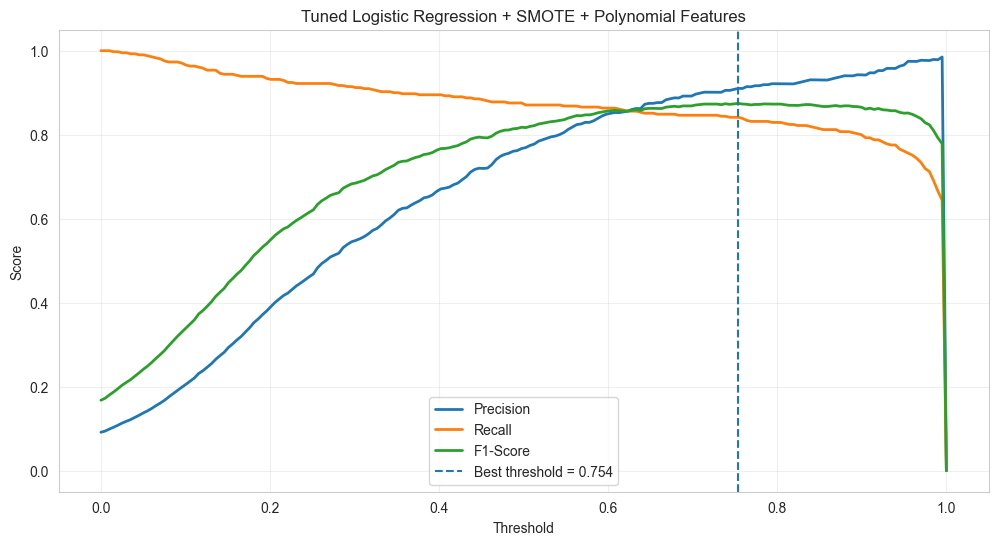

Best threshold on test: 0.754
Accuracy at best threshold: 0.9779
Precision at best threshold: 0.9103
Recall at best threshold: 0.8415
F1-Score at best threshold: 0.8745

--- Scores at threshold 0.5 (for comparison) ---
Accuracy at threshold 0.5: 0.9642
Precision at threshold 0.5: 0.7671
Recall at threshold 0.5: 0.8756
F1-Score at threshold 0.5: 0.8178


In [ ]:
def tuned_logreg_max_f1(train_dataset, test_dataset, target_column="target"):
    # Split into X/y
    X_train = train_dataset.drop(columns=[target_column])
    y_train = train_dataset[target_column]
    X_test = test_dataset.drop(columns=[target_column])
    y_test = test_dataset[target_column]

    # Pipeline: SMOTE -> PolynomialFeatures -> StandardScaler -> LogisticRegression
    pipe = ImbPipeline(
        [
            ("smote", SMOTE(random_state=42)),
            ("poly", PolynomialFeatures(include_bias=False)),
            ("scaler", StandardScaler()),
            ("logistic", LogisticRegression(max_iter=1000)),
        ]
    )

    # Hyperparameter grid (you can enlarge it if you want to search more)
    param_grid = {
        "poly__degree": [1, 2, 3],  # 1 = no polynomial, 2 or 3 add interactions
        "logistic__C": [0.01, 0.1, 1.0, 10.0],  # regularization strength
        "logistic__class_weight": [None, "balanced"],
    }

    # F1 scorer for the positive class
    f1_scorer = make_scorer(f1_score, pos_label=1)

    # Stratified CV
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Grid search to maximize F1
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=cv,
        n_jobs=-1,
        verbose=1,
    )

    grid.fit(X_train, y_train)

    print("Best hyperparameters:", grid.best_params_)
    print(f"Best CV F1 (train/val): {grid.best_score_:.4f}")

    # Use best model on the test set
    best_model = grid.best_estimator_
    y_scores = best_model.predict_proba(X_test)[:, 1]

    # Threshold sweep on the test probabilities
    thresholds = np.linspace(0, 1, 200)
    precisions, recalls, f1s = [], [], []

    for thr in thresholds:
        y_pred_thr = (y_scores >= thr).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred_thr, average="binary", zero_division=0
        )
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    best_idx = int(np.argmax(f1s))
    best_thr = thresholds[best_idx]
    best_f1 = f1s[best_idx]
    best_precision = precisions[best_idx]
    best_recall = recalls[best_idx]

    # Plot curves
    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, precisions, label="Precision", linewidth=2)
    plt.plot(thresholds, recalls, label="Recall", linewidth=2)
    plt.plot(thresholds, f1s, label="F1-Score", linewidth=2)
    plt.axvline(best_thr, linestyle="--", label=f"Best threshold = {best_thr:.3f}")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Tuned Logistic Regression + SMOTE + Polynomial Features")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Final metrics at best threshold
    y_pred_best = (y_scores >= best_thr).astype(int)
    acc = accuracy_score(y_test, y_pred_best)

    print(f"Best threshold on test: {best_thr:.3f}")
    print(f"Accuracy at best threshold: {acc:.4f}")
    print(f"Precision at best threshold: {best_precision:.4f}")
    print(f"Recall at best threshold: {best_recall:.4f}")
    print(f"F1-Score at best threshold: {best_f1:.4f}")

    # Calculate and print scores at threshold 0.5 for fair comparison
    print("\n--- Scores at threshold 0.5 (for comparison) ---")
    y_pred_05 = (y_scores >= 0.5).astype(int)
    acc_05 = accuracy_score(y_test, y_pred_05)
    precision_05, recall_05, f1_05, _ = precision_recall_fscore_support(
        y_test, y_pred_05, average="binary", zero_division=0
    )
    print(f"Accuracy at threshold 0.5: {acc_05:.4f}")
    print(f"Precision at threshold 0.5: {precision_05:.4f}")
    print(f"Recall at threshold 0.5: {recall_05:.4f}")
    print(f"F1-Score at threshold 0.5: {f1_05:.4f}")


# Run the tuned experiment
tuned_logreg_max_f1(train_data, test_data, target_column="target")

In [ ]:
from xgboost import XGBClassifier

from sklearn.model_selection import (
    StratifiedKFold,
    RandomizedSearchCV,
    train_test_split,
)
from sklearn.metrics import f1_score, precision_recall_fscore_support, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# X and y as defined in your notebook:
X = df_to_model.drop(columns=["target"])
X["Z-Score"] = X["Mean"] / X["Std"]
y = df_to_model["target"]

train_dataset = X.copy()
train_dataset["target"] = y

train_data, test_data = train_test_split(
    train_dataset, stratify=train_dataset["target"], random_state=42
)

In [ ]:
def xgb_max_f1(train_dataset, test_dataset, target_column="target", n_iter=50):
    # Split X/y
    X_train = train_dataset.drop(columns=[target_column])
    y_train = train_dataset[target_column]
    X_test = test_dataset.drop(columns=[target_column])
    y_test = test_dataset[target_column]

    # Class imbalance ratio for scale_pos_weight
    neg = (y_train == 0).sum()
    pos = (y_train == 1).sum()
    ratio = neg / pos

    # Base model
    xgb = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        tree_method="hist",  # faster; remove or change if not available
    )

    # Hyperparameter search space
    param_dist = {
        "n_estimators": [200, 400, 600, 800],
        "max_depth": [3, 4, 5, 6],
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "gamma": [0.0, 0.5, 1.0],
        "reg_lambda": [1.0, 5.0, 10.0],
        "min_child_weight": [1, 3, 5],
        # explore around the true imbalance ratio
        "scale_pos_weight": [ratio * 0.5, ratio, ratio * 2.0],
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring="f1",  # directly optimize F1 in CV
        n_jobs=-1,
        cv=cv,
        verbose=1,
        random_state=42,
    )

    search.fit(X_train, y_train)

    print("Best hyperparameters:")
    print(search.best_params_)
    print(f"Best CV F1 (train/val): {search.best_score_:.4f}")

    best_model = search.best_estimator_

    # Predict probabilities on the test set
    y_scores = best_model.predict_proba(X_test)[:, 1]

    # Sweep thresholds to maximize F1
    thresholds = np.linspace(0, 1, 500)
    precisions, recalls, f1s = [], [], []

    for thr in thresholds:
        y_pred_thr = (y_scores >= thr).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred_thr, average="binary", zero_division=0
        )
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    best_idx = int(np.argmax(f1s))
    best_thr = thresholds[best_idx]
    best_f1 = f1s[best_idx]
    best_precision = precisions[best_idx]
    best_recall = recalls[best_idx]

    # Plot precision/recall/F1 vs threshold
    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, precisions, label="Precision", linewidth=2)
    plt.plot(thresholds, recalls, label="Recall", linewidth=2)
    plt.plot(thresholds, f1s, label="F1-Score", linewidth=2)
    plt.axvline(best_thr, linestyle="--", label=f"Best threshold = {best_thr:.3f}")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("XGBoost – Precision, Recall, and F1 vs Threshold")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Final metrics at best threshold
    y_pred_best = (y_scores >= best_thr).astype(int)
    acc = accuracy_score(y_test, y_pred_best)

    print(f"Best threshold on test: {best_thr:.3f}")
    print(f"Accuracy at best threshold: {acc:.4f}")
    print(f"Precision at best threshold: {best_precision:.4f}")
    print(f"Recall at best threshold: {best_recall:.4f}")
    print(f"F1-Score at best threshold: {best_f1:.4f}")

    return best_model, best_thr

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters:
{'subsample': 1.0, 'scale_pos_weight': np.float64(4.960943856794142), 'reg_lambda': 10.0, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.6}
Best CV F1 (train/val): 0.8607
Best hyperparameters:
{'subsample': 1.0, 'scale_pos_weight': np.float64(4.960943856794142), 'reg_lambda': 10.0, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.6}
Best CV F1 (train/val): 0.8607


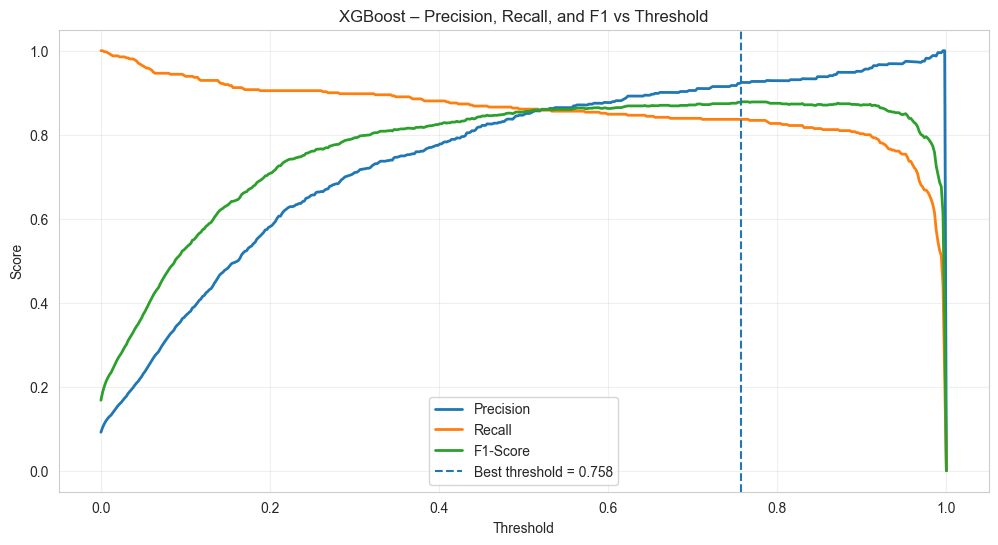

Best threshold on test: 0.758
Accuracy at best threshold: 0.9788
Precision at best threshold: 0.9245
Recall at best threshold: 0.8366
F1-Score at best threshold: 0.8784


In [ ]:
best_xgb_model, best_xgb_threshold = xgb_max_f1(
    train_data, test_data, target_column="target"
)